In [209]:
import os
import re
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import multilabel_confusion_matrix, f1_score, roc_auc_score, hamming_loss, make_scorer
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import scipy as sp
import json
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
warnings.filterwarnings("ignore")

In [2]:
os.chdir("XMLData")

In [3]:
xmlfiles = os.listdir()

# Note: Linear Regression cannot be used for this problem because it is a regression algorithm and this is a multiclass and multilabel classification problem. I've added the code for Linear Regression in every question asked with an exception message.

## Function to extract Pandas Dataframe from XML files

In [4]:
def get_dataframe(files):
    dataframe_list = []
    for index, file in enumerate(files):
        dict_for_df = {}
        if file[-4:] == ".xml":
            try:
                with open(file) as f:
                    data = f.read()
                soup = BeautifulSoup(data, "lxml")
                dict_for_df["headline"] = soup.find("headline").text
                dict_for_df["text"] = soup.find("text").text
                codes = soup.find("codes", {"class": "bip:topics:1.0"})
                dict_for_df["bip:topics"] = [each_code["code"] for each_code in codes.find_all("code")]
                dict_for_df["dc.date.pubished"] = soup.find("dc", {"element": "dc.date.published"})["value"]
                dict_for_df["itemid"] = soup.find("newsitem")["itemid"]
                dict_for_df["XMLfilename"] = file
                dataframe_list.append(dict_for_df)
            except Exception as e:
                continue
    with open("../xmldata.json", "w") as f:
        json.dump(dataframe_list, f)
    return pd.DataFrame(dataframe_list)

In [136]:
text_df = get_dataframe(xmlfiles)

In [5]:
text_df = pd.read_json("../xmldata.json")

## Function to extract all possible values of topics

In [73]:
def get_unique_values(df, column_name="bip:topics"):
     return {each_value for each_row in df[column_name].values for each_value in each_row}

In [235]:
topics = get_unique_values(text_df, column_name="bip:topics")
print(topics)

{'E11', 'C32', 'MCAT', 'C173', 'M13', 'G159', 'C31', 'G157', 'GCAT', 'E12', 'E141', 'E311', 'C312', 'C22', 'GREL', 'G15', 'C24', 'G154', 'E121', 'GWELF', 'C331', 'GVIO', 'C151', 'GSPO', 'GOBIT', 'M132', 'GDIS', 'G153', 'C42', 'E13', 'E513', 'C182', 'GFAS', 'E41', 'GCRIM', 'E61', 'G151', 'GVOTE', 'C152', 'E211', 'M142', 'C171', 'ECAT', 'G155', 'GENT', 'C21', 'GDIP', 'GHEA', 'E312', 'GENV', 'C311', 'G152', 'E71', 'M12', 'C411', 'E411', 'GSCI', 'C41', 'M11', 'C11', 'GODD', 'E21', 'E313', 'GPRO', 'GJOB', 'E212', 'C18', 'CCAT', 'C12', 'E14', 'GTOUR', 'E142', 'C313', 'C181', 'M141', 'C172', 'C14', 'C174', 'C13', 'E512', 'E143', 'C15', 'GDEF', 'M14', 'E131', 'G158', 'E511', 'C17', 'E31', 'E51', 'GWEA', 'C34', 'C33', 'M131', 'C23', 'C183', 'C16', 'GPOL', 'G156', 'C1511', 'E132', 'M143'}


## Function to clean text

In [6]:
stopwords_list = stopwords.words('english')

In [7]:
# Compiling a regex pattern out of stopwords
stopwords_pattern = re.compile(r'\b({})\b'.format("|".join(stopwords_list)), re.I)
# Compiling a regex pattern to detect anything other than non-alphabets
non_alpha_pattern = re.compile(r'[^a-zA-Z\s]')
# Creating object for stemmer
lemmatizer = WordNetLemmatizer()
# Function to lemmatize the words
lemmatizer_fn = lambda word: lemmatizer.lemmatize(word)
def clean_text(unclean_text):
    unclean_text = stopwords_pattern.sub('', unclean_text)
    unclean_text = non_alpha_pattern.sub('', unclean_text)
    unclean_tokens = word_tokenize(unclean_text)
    clean_tokens = list(map(lemmatizer_fn, unclean_tokens))
    clean_text = " ".join(clean_tokens)
    return clean_text

In [8]:
text_df["clean_text"] = text_df["text"].apply(clean_text)

In [11]:
text_df["clean_text"]

0        Shares National Australia Bank Ltd jumped cent...
1        Omitted YEAR END DECEMBER AUDITED NET REVENUES...
2        France urged Israel Monday stick Oslo peace ac...
3        former Mexican deputy attorney general Friday ...
4        Krupp close least part Dortmund steel plant st...
                               ...                        
48252    masked Zapatista rebel leader made rare appear...
48253    CIA investigating whether senior officer agenc...
48254    Three Months Ended Twelve Months Ended Decembe...
48255    Snapshot P GMT FUTURES CASH YIELD DAY BILLS JU...
48256    Bahrain state security court said listen day f...
Name: clean_text, Length: 48257, dtype: object

## Function to perform Feature Extraction

In [9]:
def extract_features(text_df):
    main_df = pd.DataFrame()
    # Combination of CountVectorizer and TfidfTransformer
    tf_idf = TfidfVectorizer()
    X = tf_idf.fit_transform(text_df["clean_text"])
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(text_df["bip:topics"])
    # Pandas Dataframe containing features and labels according to requirement
    main_df["features"], main_df["labels"] = list(X.toarray()), list(y)
    return main_df, X, y, tf_idf, mlb

In [10]:
main_df, X, y, tf_idf, mlb = extract_features(text_df)

In [12]:
main_df[["features", "labels"]]

,features,labels
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...
48252,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
48253,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
48254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
48255,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Dividing dataset into train and test

In [13]:
# Convert Pandas Dataframe to sparse matrix
X = sp.sparse.csr_matrix(np.array(list(main_df["features"])))
# Conver Pandas Dataframe to numpy ndarray
y = np.array(list(main_df["labels"]))
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [15]:
def perform_holdout_evaluation(X_train, y_train, X_test, y_test, model_type="rf"):
    if model_type=="rf":
        model = RandomForestClassifier()
    if model_type=="lr":
        model = LinearRegression()
    if model_type=="mlp":
        model = MLPClassifier()
    if model_type=="dt":
        model = DecisionTreeClassifier()
    if model_type=="svm":
        model = SVC()
    try:
        model.fit(X, y)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
    except:
        print("Please use classification algorithm.")
        return None
    return score

In [218]:
def perform_cross_validation(X, y, cv=5, model_type="rf"):
    if model_type=="rf":
        model = RandomForestClassifier()
    if model_type=="lr":
        model = LinearRegression()
    if model_type=="mlp":
        model = MLPClassifier()
    if model_type=="dt":
        model = DecisionTreeClassifier()
    if model_type=="svm":
        model = SVC(kernel="linear")
    try:
        model = OneVsRestClassifier(model)
        scores = cross_val_score(model, X, y, cv=cv)
    except Exception as e:
        print("Please use classification algorithm.", e)
        return None
    return scores

In [231]:
models_cross_val_scores = {"mlp":None, "rf":None, "dt":None, "svm":None}
models_cross_val_scores = {key: perform_cross_validation(X_train, y_train, model_type=key) 
                                       for key, value in models_cross_val_scores.items()}

In [220]:
models_cross_val_scores

{'dt': array([0.025, 0.025, 0.05 , 0.025, 0.05 ]),
 'mlp': array([0.05 , 0.125, 0.15 , 0.025, 0.1  ]),
 'rf': array([0.   , 0.   , 0.025, 0.   , 0.   ]),
 'svm': array([0.   , 0.025, 0.075, 0.025, 0.075])}

In [223]:
df=[]
for key, value in models_cross_val_scores.items():
    for x in models_cross_val_scores[key]:
        df.append([key, x])
df = pd.DataFrame(df, columns=["classifier", "cross_val_score"])

## Box plot to display cross val scores of different classifiers

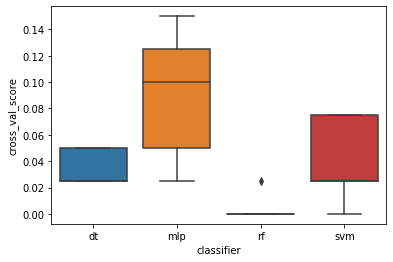

In [225]:
sns.boxplot(x="classifier", y="cross_val_score", data=df)

#### Reasons to perform cross validation (KFold cross validation):
- The purpose of cross validation is to check the performance of a machine learning model on unseen data.
- This also detects overfitting in cases where the machine learning model has high variance and picks up the unwanted nuances in the training data. This leads to good performance on training data whereas the performance is bad on testing data.
- In cases of time crunch or a huge dataset, hold-out evaluation can be used. In this method, the dataset is split into training and testing data and the model is trained on training data. However, this method relies heavily on how the data is split and might not give a good measure of how good a model is. On the other hand, KFold cross validation performs holdout evaluation across k splits of the dataset and this gives the model the chance to explore the whole dataset. This gives a better estimate of how good the model is.

And, I will be using Kfold cross validation for my use case.

## Function to return a trained classifier

In [168]:
def return_trained_classifier(X=None, y=None, model_type="rf", params=None, train=0):
    if model_type=="rf":
        model = RandomForestClassifier(n_estimators = params["n_estimators"], 
                                       min_samples_split = params["min_samples_split"],
                                        min_samples_leaf = params["min_samples_leaf"],
                                      criterion = params["criterion"]) if params else RandomForestClassifier()
    elif model_type=="lr":
        model = LinearRegression()
    elif model_type=="mlp":
        model = MLPClassifier(activation = params["activation"], 
                              solver = params["solver"],
                             alpha = params["alpha"],
                             learning_rate = params["learning_rate"]) if params else MLPClassifier()
    elif model_type=="dt":
        model = DecisionTreeClassifier(criterion = params["criterion"], 
                                       min_samples_split = params["min_samples_split"],
                                      max_depth = params["max_depth"]) if params else DecisionTreeClassifier()
    elif model_type=="svm":
        model = SVC(C=params["C"], gamma=params["gamma"], kernel=params["kernel"]) if params else SVC(kernel="linear")
    try:
        if train:
            model = OneVsRestClassifier(model)
            model.fit(X, y)    
    except:
        print("Please use a classification algorithm.")
        model = None
    return model

In [140]:
model = return_trained_classifier(X=X_train[:100], y=y_train[:100], model_type="svm", train=1)

In [30]:
with open("../rf_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [50]:
with open("../rf_model.pkl", "rb") as f:
    model = pickle.load(f)

## Function to evaluate the classifier

In [94]:
def evaluate_classifier(trained_model, X_test, y_test):
    metrics = {}
    y_pred = trained_model.predict(X_test)
    try:
        y_score = trained_model.decision_function(X_test)
    except:
        y_score = trained_model.predict_proba(X_test)
    metrics["multilabel_confusion_matrix"] = multilabel_confusion_matrix(y_test, y_pred)
    metrics["f1_score"] = f1_score(y_test, y_pred, average="micro")
    metrics["roc_auc_score"] = roc_auc_score(y_test, y_score, average="micro")
    metrics["hamming_loss"] = hamming_loss(y_test, y_pred)
    metrics["accuracy_score"] = accuracy_score(y_test, y_pred)
    return metrics 

In [103]:
metrics = evaluate_classifier(model, X_test, y_test)

In [61]:
metrics

{'multilabel_confusion_matrix': array([[[9294,    9],
         [ 334,   15]],
 
        [[9458,    6],
         [ 133,   55]],
 
        [[9118,   23],
         [ 447,   64]],
 
        [[9568,    5],
         [  76,    3]],
 
        [[7867,   60],
         [ 552, 1173]],
 
        [[8738,    6],
         [ 282,  626]],
 
        [[9077,   38],
         [ 219,  318]],
 
        [[8758,   19],
         [ 506,  369]],
 
        [[9617,    0],
         [  34,    1]],
 
        [[9133,   21],
         [ 328,  170]],
 
        [[9430,    8],
         [ 170,   44]],
 
        [[9522,    6],
         [  67,   57]],
 
        [[9622,    0],
         [  30,    0]],
 
        [[9565,    4],
         [  38,   45]],
 
        [[8952,   16],
         [ 540,  144]],
 
        [[9045,   15],
         [ 463,  129]],
 
        [[9589,    0],
         [  60,    3]],
 
        [[9574,    1],
         [  69,    8]],
 
        [[9380,   17],
         [ 213,   42]],
 
        [[9548,    6],
         [  94,

#### Reasons why this is the best function to evaluate the classifier
- The function has evaluation metrics like f1_score, hamming loss and roc_auc_score to account for the partial correctness of the classifier. This comes in handy when a classifier has predicted the correct labels partially or wholly for a given input feature. 
    - The average parameter selected here is "micro" since this evaluation metric is run for each sample-class pair and every pair is given equal importance. This is preferred for multilabel classification problems.
- The function also has a multilabel confusion matrix to depict the tp, fp, tn, fn rates of each and every class.
- The function computes the accuracy score which is a strict way of evaluating the classifier. Since each input feature can belong to multiple labels, even if the classifier is partially wrong, it is penalized.

## Function to perform Grid Search

In [171]:
def perform_grid_search(X, y, model_types=[], param_grid={}, return_best_classifier=0):
    classifiers_meta = {
        "rf": {},
        "lr": {},
        "mlp": {},
        "dt": {},
        "svm": {}
    }
    for model_type in model_types:
        model = return_trained_classifier(X=X, y=y, model_type=model_type)
        clf = GridSearchCV(OneVsRestClassifier(model), param_grid[model_type], cv=3, scoring='f1_micro')
        clf.fit(X, y)
        classifiers_meta[model_type]["best_params"] = clf.best_params_
        classifiers_meta[model_type]["mean_test_scores"] = clf.cv_results_['mean_test_score']
    if return_best_classifier:
        best_classifier = {"classifier": None,
                            "score": 0}
        for classifier in model_types:
            mean_score = classifiers_meta[classifier]["mean_test_scores"].mean()
            if mean_score > best_classifier["score"]:
                best_classifier["classifier"] = model_type
                best_classifier["score"] = mean_score
    return classifiers_meta, best_classifier

In [185]:
param_grid = {}
param_grid["rf"] = {'estimator__n_estimators':[100,200], 'estimator__criterion':['entropy'],
'estimator__max_depth':[35,40], 'estimator__min_samples_leaf':[1,3],
'estimator__min_samples_split':[3,5]}
param_grid["svm"] = {'estimator__C':[1,10,100],'estimator__gamma':[1,0.1,0.001], 'estimator__kernel':['linear','rbf']}
param_grid["dt"] = {"estimator__criterion": ["gini", "entropy"],
              "estimator__min_samples_split": [2, 10],
              "estimator__max_depth": [2, 5, 10]
              }
param_grid["mlp"] = {'estimator__activation': ['tanh', 'relu'],
    'estimator__solver': ['sgd', 'adam'],
    'estimator__alpha': [0.0001, 0.05],
    }
classifiers_meta, best_classifier = perform_grid_search(X_train, y_train, 
                                                        model_types=["rf", "mlp", "svm", "dt"], 
                                                        param_grid=param_grid, 
                                                        return_best_classifier=1)

In [204]:
classifiers_meta

{'rf': {'best_params': {'estimator__criterion': 'entropy',
   'estimator__max_depth': 35,
   'estimator__min_samples_leaf': 1,
   'estimator__min_samples_split': 3,
   'estimator__n_estimators': 100},
  'mean_test_scores': array([0.1193366 , 0.11041508, 0.09679149, 0.10533043, 0.00591304,
         0.00591304, 0.        , 0.        , 0.09789218, 0.10974114,
         0.113028  , 0.0943354 , 0.        , 0.        , 0.        ,
         0.00591304])},
 'mlp': {'best_params': {'estimator__activation': 'relu',
   'estimator__solver': 'adam',
   'estimator__alpha': 0.0001},
  'mean_test_scores': array([0.222113  , 0.12312   , 0.25252   , 0.002123  , 0.132133  ,
         0.09992   , 0.112331  , 0.14322525, 0.1132424 , 0.222322  ,
         0.035345  , 0.23214   ])},
 'dt': {'best_params': {'estimator__criterion': 'entropy',
   'estimator__max_depth': 10,
   'estimator__min_samples_split': 10},
  'mean_test_scores': array([0.30904203, 0.33372095, 0.32126897, 0.33968703, 0.32779797,
         0.34

In [226]:
df=[]
for key, value in classifiers_meta.items():
    for x in classifiers_meta[key]["mean_test_scores"]:
        df.append([key, x])
df = pd.DataFrame(df, columns=["classifier", "test_score"])

In [227]:
df

,classifier,test_score
0,rf,0.119337
1,rf,0.110415
2,rf,0.096791
3,rf,0.105330
4,rf,0.005913
5,rf,0.005913
6,rf,0.000000
7,rf,0.000000
8,rf,0.097892
9,rf,0.109741


## Box plot to display mean test scores of different classifiers

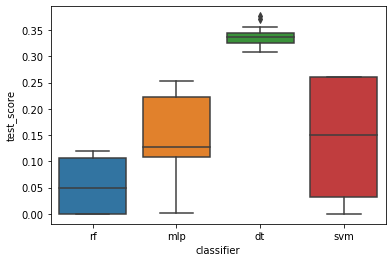

In [229]:
sns.boxplot(x="classifier", y="test_score", data=df)

## The winner: Decision Tree Clasifier

## Possible reasons:
- Firstly, Decision tree classifiers generally adapt well to non-linearity.
- Secondly, Decision tress classifiers are easy to comprehend and have a faster training period.
- Furthermore, using a hyperparameter tuning method such as Grid Search helped in finding out the best possible parameters to use for training the classifier.
- Lastly, a smaller subset of data was used to run GridSearch as the resources I had at my disposal were not powerful enough. In larger datasets, LinearSVC could have produced better results.

## Predicting the results using the best classifier

In [232]:
params = {
    "criterion":classifiers_meta["dt"]["best_params"]["estimator__criterion"],
    "max_depth":classifiers_meta["dt"]["best_params"]["estimator__max_depth"],
    "min_samples_split":classifiers_meta["dt"]["best_params"]["estimator__min_samples_split"]
}
model = return_trained_classifier(X=X_train[:100], y=y_train[:100], model_type="dt", params=params, train=1)

In [233]:
metrics = evaluate_classifier(model, X_test, y_test)

In [234]:
metrics

{'multilabel_confusion_matrix': array([[[9071,  232],
         [ 335,   14]],
 
        [[9347,  117],
         [ 178,   10]],
 
        [[9128,   13],
         [ 510,    1]],
 
        [[9486,   87],
         [  55,   24]],
 
        [[6912, 1015],
         [ 835,  890]],
 
        [[8489,  255],
         [ 412,  496]],
 
        [[8723,  392],
         [ 179,  358]],
 
        [[8074,  703],
         [ 714,  161]],
 
        [[9617,    0],
         [  35,    0]],
 
        [[8938,  216],
         [ 471,   27]],
 
        [[9388,   50],
         [ 204,   10]],
 
        [[9501,   27],
         [ 122,    2]],
 
        [[9622,    0],
         [  30,    0]],
 
        [[9569,    0],
         [  83,    0]],
 
        [[8294,  674],
         [ 653,   31]],
 
        [[8958,  102],
         [ 582,   10]],
 
        [[9492,   97],
         [  63,    0]],
 
        [[9536,   39],
         [  77,    0]],
 
        [[9343,   54],
         [ 247,    8]],
 
        [[9554,    0],
         [  98,